# Train macro classifiers with masking for missing data

# Window jitter and time shift data augmentation is added

In [7]:
import glob
import os
import numpy as np
import csv
import io
from sklearn.preprocessing import StandardScaler
import shutil

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Options to set if needed

In [9]:
# from keras.backend.tensorflow_backend import set_session
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default 

In [2]:
data_dir_train='data_2/train'
data_dir_val= 'data_2/val'
data_dir_test= 'data_2/test'

In [3]:
sub_dirs = ['left_hip','right_arm','right_wrist' ] #three sensors, 9 channels total

In [4]:
#correcting the buckets information

def parse_IMU_files(parent_dir, sub_dirs, startTime, endTime, file_name, window_length):
    
    data = []
    data_mask = []
    
    data_count = 0
    
    for sub_dir in sub_dirs:
        
        channel=[[0.0, 0.0, 0.0]]*window_length
        
        mask = [0.0]*window_length
        
        div_bucket = int(10000/window_length)
        
        for fn in glob.glob(os.path.join(parent_dir,sub_dir, file_name)):
            file = open(fn, newline='')
            reader = csv.reader(file)
            first = True
            count = 0
            for row in reader:
                
                if first:
                    first = False
                    continue
                
                timestamp=float(row[3]) #4th column is timestamp
                if timestamp >=startTime and timestamp <=endTime and count<window_length:
                    
                    curr_bucket = timestamp - startTime #can go from 0 to 10,000
                    
                    curr_bucket = int(curr_bucket/div_bucket) #can go from 0 to 500
                    
                    
                    if curr_bucket<window_length:
                        channel[curr_bucket] = [float(row[0]),float(row[1]),float(row[2])]
                        mask[curr_bucket] = 1.0

                        count = count + 1 
                        data_count = data_count+1
                    
                    
        data.append(channel) 
        data_mask.append(mask)
    return data, data_mask, data_count

In [5]:
data_min_count = 100 # per sample, valid points

In [6]:
# Masking info added

def get_train_data(data_dir, sub_dirs):
    files = os.listdir(data_dir+'/left_hip')
    number_of_samples = 500
    
    labels_macro =dict()
    
    labels_macro['sandwich'] = 0
    labels_macro['fruitsalad'] = 1
    labels_macro['cereal'] = 2
    
    
    #read the labels
    labels_loc = 'data/LabelTable.csv'
    file_label = open(labels_loc, newline='')
    label_reader = csv.reader(file_label)
    file_label_mapping = dict()
    
    first = True
    for row in label_reader:
        
        if first:
            first = False
            continue
        
        file_label_mapping[row[0]+'.csv'] = labels_macro[row[1]]
        
    all_data = []
    all_labels = []
    for f in files:
        
        st_index = 0
        end_index = 30000
        step = 1000 #overlapping window, step: 1000. 
        window_index = 10000 #10 second window
        
        print('reading file:',f)
        f_name = f
        
        if f_name == '.DS_Store':
            continue
        
        curr_label_file = file_label_mapping[f_name]
        
        while st_index+step < end_index:
        
            data, data_mask, data_count = parse_IMU_files(data_dir, sub_dirs, st_index, st_index+window_index,  f, number_of_samples)
            
            st_index = st_index+step
            
            if data_count<data_min_count:
                continue
            
            train_data_sample  = np.zeros((12, number_of_samples))
            train_data_label   = curr_label_file
            for i in range(len(data)):
                for j in range(len(data[i])):
                    train_data_sample[i*4,j]=data[i][j][0]
                    train_data_sample[i*4+1,j]=data[i][j][1]
                    train_data_sample[i*4+2,j]=data[i][j][2]
                    
                    #mask information
                    train_data_sample[i*4+3,j]=data_mask[i][j]
            
            all_data.append(train_data_sample)
            all_labels.append(train_data_label)
        
        #break
            
    return all_data, all_labels

In [1]:
#receive windowed training and validation data
train_x, train_y = get_train_data(data_dir_train,sub_dirs)
val_x, val_y = get_train_data(data_dir_val,sub_dirs)
test_x, test_y = get_train_data(data_dir_test,sub_dirs)

In [9]:
#correcting the buckets information

import random

def parse_IMU_files_2(parent_dir, sub_dirs, startTime, endTime, file_name, window_length):
    
    data = []
    data_mask = []
    
    data_count = 0
    
    for sub_dir in sub_dirs:
        
        channel=[[0.0, 0.0, 0.0]]*window_length
        
        mask = [0.0]*window_length
        
        div_bucket = int(10000/window_length)
        
        for fn in glob.glob(os.path.join(parent_dir,sub_dir, file_name)):
            file = open(fn, newline='')
            reader = csv.reader(file)
            first = True
            count = 0
            for row in reader:
                
                if first:
                    first = False
                    continue
                
                timestamp=float(row[3]) #4th column is timestamp
                
                window_jitter1 = random.randint(-150,150)
                
                window_jitter2 = random.randint(-150,150)
                
                
                if timestamp >=(startTime+window_jitter1) and timestamp <=(endTime+window_jitter2) and count<window_length:
                    
                    curr_bucket = timestamp - startTime #can go from 0 to 10,000
                    
                    curr_bucket = int(curr_bucket/div_bucket) #can go from 0 to 500
                    
                    if curr_bucket<window_length:
                        channel[curr_bucket] = [float(row[0]),float(row[1]),float(row[2])]
                        mask[curr_bucket] = 1.0

                        count = count + 1 
                        data_count = data_count+1                   
                    
        data.append(channel) 
        data_mask.append(mask)
    return data, data_mask, data_count



def parse_IMU_files_3(parent_dir, sub_dirs, startTime, endTime, file_name, window_length):
    
    data = []
    data_mask = []
    
    data_count = 0
    
    for sub_dir in sub_dirs:
        
        channel=[[0.0, 0.0, 0.0]]*window_length
        
        mask = [0.0]*window_length
        
        div_bucket = int(10000/window_length)
        
        window_jitter1 = random.randint(-1500,1500)
        window_jitter2 = random.randint(-1500,1500)
                
        
        for fn in glob.glob(os.path.join(parent_dir,sub_dir, file_name)):
            file = open(fn, newline='')
            reader = csv.reader(file)
            first = True
            count = 0
            for row in reader:
                
                if first:
                    first = False
                    continue
                
                timestamp=float(row[3]) #4th column is timestamp
                
                
                if timestamp >=(startTime+window_jitter1) and timestamp <=(endTime+window_jitter2) and count<window_length:
                    
                    curr_bucket = timestamp - startTime #can go from 0 to 10,000
                    
                    curr_bucket = int(curr_bucket/div_bucket) #can go from 0 to 500
                    
                    if curr_bucket<window_length:
                        channel[curr_bucket] = [float(row[0]),float(row[1]),float(row[2])]
                        mask[curr_bucket] = 1.0

                        count = count + 1 
                        data_count = data_count+1                   
                    
        data.append(channel) 
        data_mask.append(mask)
    return data, data_mask, data_count

In [10]:
# Masking info added

def get_train_data_2(data_dir, sub_dirs):
    files = os.listdir(data_dir+'/left_hip')
    number_of_samples = 500
    
    labels_macro =dict()
    
    labels_macro['sandwich'] = 0
    labels_macro['fruitsalad'] = 1
    labels_macro['cereal'] = 2
    
    
    #read the labels
    labels_loc = 'data/LabelTable.csv'
    file_label = open(labels_loc, newline='')
    label_reader = csv.reader(file_label)
    file_label_mapping = dict()
    
    first = True
    for row in label_reader:
        
        if first:
            first = False
            continue
        
        file_label_mapping[row[0]+'.csv'] = labels_macro[row[1]]
        
    all_data = []
    all_labels = []
    for f in files:
        
        st_index = 0
        end_index = 30000
        step = 1000 #overlapping window, step: 1000. 
        window_index = 10000 #10 second window
        
        print('reading file:',f)
        f_name = f
        
        if f_name == '.DS_Store':
            continue
        
        curr_label_file = file_label_mapping[f_name]
        
        while st_index+step < end_index:
        
            data, data_mask, data_count = parse_IMU_files_2(data_dir, sub_dirs, st_index, st_index+window_index,  f, number_of_samples)    
            st_index = st_index+step
            
            if data_count<data_min_count:
                continue
            
            train_data_sample  = np.zeros((12, number_of_samples))
            train_data_label   = curr_label_file
            for i in range(len(data)):
                for j in range(len(data[i])):
                    train_data_sample[i*4,j]=data[i][j][0]
                    train_data_sample[i*4+1,j]=data[i][j][1]
                    train_data_sample[i*4+2,j]=data[i][j][2]
                    
                    #mask information
                    train_data_sample[i*4+3,j]=data_mask[i][j]
            
            all_data.append(train_data_sample)
            all_labels.append(train_data_label)
        
        #break
            
    return all_data, all_labels


# Masking info added

def get_train_data_3(data_dir, sub_dirs):
    files = os.listdir(data_dir+'/left_hip')
    number_of_samples = 500
    
    labels_macro =dict()
    
    labels_macro['sandwich'] = 0
    labels_macro['fruitsalad'] = 1
    labels_macro['cereal'] = 2
    
    
    #read the labels
    labels_loc = 'data/LabelTable.csv'
    file_label = open(labels_loc, newline='')
    label_reader = csv.reader(file_label)
    file_label_mapping = dict()
    
    first = True
    for row in label_reader:
        
        if first:
            first = False
            continue
        
        file_label_mapping[row[0]+'.csv'] = labels_macro[row[1]]
        
    all_data = []
    all_labels = []
    for f in files:
        
        st_index = 0
        end_index = 30000
        step = 1000 #overlapping window, step: 1000. 
        window_index = 10000 #10 second window
        
        print('reading file:',f)
        f_name = f
        
        if f_name == '.DS_Store':
            continue
        
        curr_label_file = file_label_mapping[f_name]
        
        while st_index+step < end_index:
        
            data, data_mask, data_count = parse_IMU_files_3(data_dir, sub_dirs, st_index, st_index+window_index,  f, number_of_samples)    
            st_index = st_index+step
            
            if data_count<data_min_count:
                continue
            
            train_data_sample  = np.zeros((12, number_of_samples))
            train_data_label   = curr_label_file
            for i in range(len(data)):
                for j in range(len(data[i])):
                    train_data_sample[i*4,j]=data[i][j][0]
                    train_data_sample[i*4+1,j]=data[i][j][1]
                    train_data_sample[i*4+2,j]=data[i][j][2]
                    
                    #mask information
                    train_data_sample[i*4+3,j]=data_mask[i][j]
            
            all_data.append(train_data_sample)
            all_labels.append(train_data_label)
        
        #break
            
    return all_data, all_labels

# Adding Window Jitters, Time Shifts and Masking Data

In [2]:
train_x2, train_y2 = get_train_data_2(data_dir_train,sub_dirs)

In [3]:
train_x3, train_y3 = get_train_data_3(data_dir_train,sub_dirs)

In [13]:
train_samples_2 = np.array(train_x2) 
train_labels2_2 = np.array(train_y2)
print(train_samples_2.shape)
print(train_labels2_2.shape)

train_samples_3 = np.array(train_x3) 
train_labels2_3 = np.array(train_y3)
print(train_samples_3.shape)
print(train_labels2_3.shape)

(4863, 12, 500)
(4863,)
(4858, 12, 500)
(4858,)


In [15]:
train_samples = np.array(train_x) 
train_labels2 = np.array(train_y)
val_samples = np.array(val_x) 
val_labels2 = np.array(val_y)
test_samples = np.array(test_x) 
test_labels2 = np.array(test_y)

In [16]:
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)

(4864, 12, 500)
(4864,)
(1348, 12, 500)
(1348,)
(1356, 12, 500)
(1356,)


In [17]:
train_samples = np.vstack((train_samples,train_samples_2, train_samples_3))
train_labels2 = np.hstack((train_labels2, train_labels2_2, train_labels2_3))

In [18]:
print(train_samples.shape)
print(train_labels2.shape)
print(val_samples.shape)
print(val_labels2.shape)
print(test_samples.shape)
print(test_labels2.shape)

(14585, 12, 500)
(14585,)
(1348, 12, 500)
(1348,)
(1356, 12, 500)
(1356,)


In [19]:
#convert to one hot encoding
from keras.utils  import to_categorical
train_labels = to_categorical(train_labels2)
train_labels.shape
val_labels = to_categorical(val_labels2)
val_labels.shape
test_labels = to_categorical(test_labels2)
test_labels.shape

(1356, 3)

In [20]:
print(train_samples.shape)
print(train_labels.shape)
print(val_samples.shape)
print(val_labels.shape)
print(test_samples.shape)
print(test_labels2.shape)

(14585, 12, 500)
(14585, 3)
(1348, 12, 500)
(1348, 3)
(1356, 12, 500)
(1356,)


In [21]:
#For CNN and BidirLSTM:
number_of_samples =500
num_of_channels = 12

train_samples = train_samples.reshape((-1, num_of_channels,number_of_samples, 1))
val_samples = val_samples.reshape((-1, num_of_channels,number_of_samples, 1))
test_samples = test_samples.reshape((-1, num_of_channels,number_of_samples, 1))

# Models

In [22]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [23]:
def _data_reshaping(X_tr, X_va, X_ts, network_type):
    _, win_len, dim = X_tr.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':

        X_tr = np.swapaxes(X_tr,1,2)
        X_va = np.swapaxes(X_va,1,2)
        X_ts = np.swapaxes(X_ts,1,2)

        X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
        X_va = np.reshape(X_va, (-1, dim, win_len, 1))
        X_ts = np.reshape(X_ts, (-1, dim, win_len, 1))
    
    return X_tr, X_va, X_ts

In [24]:
from keras import regularizers

def model_variant(model, num_feat_map, dim, network_type,p):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) 
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(Bidirectional(LSTM(128, return_sequences=False, stateful=False)))
    if network_type == 'CNN':
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization()) 
        model.add(Dropout(p))

        
def model_conv(model, num_feat_map,p,b):
    model.add(Conv2D(num_feat_map, kernel_size=(1, 10),    
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    
    model.add(Conv2D(num_feat_map, kernel_size=(1, 10), activation='relu',padding='same'))
    
    if (b==1):
        model.add(BatchNormalization()) 
    model.add(Conv2D(num_feat_map, kernel_size=(1, 10), activation='relu',padding='same'))
    
    if (b==1):
        model.add(BatchNormalization()) 
    model.add(MaxPooling2D(pool_size=(1, 3)))
    
    model.add(Conv2D(num_feat_map, kernel_size=(1, 10), activation='relu',padding='same')) 
    model.add(Conv2D(num_feat_map, kernel_size=(1, 10), activation='relu',padding='same'))
    if (b==1):
        model.add(BatchNormalization()) 
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    
    model.add(Conv2D(num_feat_map, kernel_size=(1, 10), activation='relu',padding='same'))  
    if (b==1):
        model.add(BatchNormalization()) 
    model.add(MaxPooling2D(pool_size=(1, 2)))
    
    model.add(Dropout(p))
    
def model_LSTM(model,p):
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(p))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(p))
    
def model_output(model):
    model.add(Dense(num_classes, activation='softmax'))

In [25]:
batch_size = 64
num_feat_map = 128
num_hidden_lstm = 128
num_classes = 3


network_type = 'ConvLSTM'

_, dim, win_len,_ = train_samples.shape

print(win_len)
print(dim)

500
12


In [26]:
p=0.5 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
       
model_output(model)    
model.summary()

building the model ... 
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

ConvLSTM
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 500, 128)      1408      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 500, 128)      512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 500, 128)      163968    
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 500, 128)      512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 166, 128)      0         
_____

In [27]:
X_train = train_samples
y_train = train_labels
X_val = val_samples
y_val = val_labels
X_test = test_samples
y_test = test_labels

In [28]:
print(X_train.shape, X_val.shape, X_test.shape)

(14585, 12, 500, 1) (1348, 12, 500, 1) (1356, 12, 500, 1)


# Add Checkpoint path to save

In [29]:
# checkpoint /home/sandeep/data/DCBL_macro_TTV_11.hdf5
filepath="macro_with_masking.hdf5"

In [6]:
epochs =40

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])


checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

callbacks_list = [checkpoint] 
H = model.fit(train_samples, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, y_val),
             callbacks=callbacks_list)

In [31]:
history = H

31


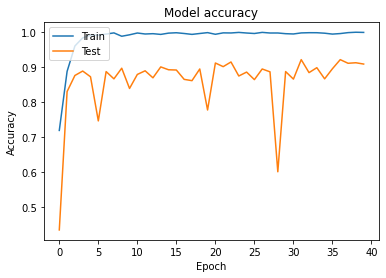

Maximum validation accuracy:  0.921364963054657
Training accuracy of best model:  0.9977374


In [32]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(np.argmax(np.array(history.history['val_accuracy'])))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print('Maximum validation accuracy: ',np.max(np.array(history.history['val_accuracy'])))
print('Training accuracy of best model: ',np.array(history.history['accuracy'])[np.argmax(np.array(history.history['val_accuracy']))])


In [33]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import itertools

# Test samples accuracy

In [34]:
model = load_model(filepath)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))

[[538  37  57]
 [ 45 309  23]
 [ 72  51 224]]
the mean-f1 score: 0.78
accuracy is: 0.79


# Train accuracy

In [35]:
model = load_model(filepath)
y_pred = np.argmax(model.predict(train_samples), axis=1)
y_true = np.argmax(train_labels, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))

[[5673    0    0]
 [   9 5095    5]
 [   0    0 3803]]
the mean-f1 score: 1.00
accuracy is: 1.00


# Validation accuracy

In [36]:
model = load_model(filepath)
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))

[[492  10  14]
 [ 26 494  24]
 [ 25   7 256]]
the mean-f1 score: 0.92
accuracy is: 0.92


# File by file the Macro comparison

In [37]:
# load the data windows per file and see their predictions

In [38]:
def get_prediction_accuracy(data_dir, sub_dirs):

    files = os.listdir(data_dir+'/left_hip')
    number_of_samples = 500

    labels_macro =dict()

    labels_macro['sandwich'] = 0
    labels_macro['fruitsalad'] = 1
    labels_macro['cereal'] = 2


    #read the labels
    labels_loc = 'data/LabelTable.csv'
    file_label = open(labels_loc, newline='')
    label_reader = csv.reader(file_label)
    file_label_mapping = dict()

    first = True
    for row in label_reader:

        if first:
            first = False
            continue

        file_label_mapping[row[0]+'.csv'] = labels_macro[row[1]]


    total_count = 0
    correct_count = 0

    for f in files:

        file_data = []
        file_label = []

        st_index = 0
        end_index = 30000
        step = 1000 #overlapping window, step: 1000. 
        window_index = 10000 #6 second window

        #print('reading file:',f)
        f_name = f

        if f_name == '.DS_Store':
            continue

        total_count = total_count+1

        curr_label_file = file_label_mapping[f_name]

        while st_index+step < end_index:

            data, data_mask, data_count = parse_IMU_files(data_dir, sub_dirs, st_index, st_index+window_index,  f, number_of_samples)
            st_index = st_index+step

            if data_count<data_min_count:
                continue

            train_data_sample  = np.zeros((12, number_of_samples))
            train_data_label   = curr_label_file
            
            #print(len(data), len(data[0]), len(data_mask[0]), data_count)
            
            for i in range(len(data)):
                for j in range(len(data[i])):
                    train_data_sample[i*4,j]=data[i][j][0]
                    train_data_sample[i*4+1,j]=data[i][j][1]
                    train_data_sample[i*4+2,j]=data[i][j][2]
                    
                    #mask information
                    train_data_sample[i*4+3,j]=data_mask[i][j]

            file_data.append(train_data_sample)
            #file_label.append(train_data_label)

        file_data = np.array(file_data)
        file_label = curr_label_file

        file_data = file_data.reshape((-1, 12,500, 1))

        y_pred = np.argmax(model.predict(file_data), axis=1) 
        counts = np.bincount(y_pred)
        prediction = np.argmax(counts) #max occuring value in windows
        
        #correct prediction
        if int(prediction)==int(file_label):
            correct_count = correct_count+1
        
    
    return total_count, correct_count        
            

In [39]:
# Test data accuracy:
total_count, correct_count = get_prediction_accuracy(data_dir_test, sub_dirs)
print('total_count of test files:', total_count)
print('correctly predicted test files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)

total_count of test files: 50
correctly predicted test files: 43
Percentage accuracy: 86.0


In [40]:
# Train accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_train, sub_dirs)
print('total_count of train files:', total_count)
print('correctly predicted train files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)

total_count of train files: 175
correctly predicted train files: 175
Percentage accuracy: 100.0


In [41]:
#val accuracy
total_count, correct_count = get_prediction_accuracy(data_dir_val, sub_dirs)
print('total_count of val files:', total_count)
print('correctly predicted val files:', correct_count)
print('Percentage accuracy:', (correct_count/total_count)*100.0)

total_count of val files: 48
correctly predicted val files: 47
Percentage accuracy: 97.91666666666666
